In [1]:
import soundfile as sf

path = "/home/batch_2024/ee24s004/KT/RMVPE-RRCGD-spot-computation/dataset/train/amy_1_07.wav"
audio, sr = sf.read(path)
audio, sr

(array([[-2.79235840e-02,  2.13623047e-04],
        [-2.25830078e-02,  1.52587891e-04],
        [-1.49230957e-02,  6.10351562e-05],
        ...,
        [-4.56848145e-02,  0.00000000e+00],
        [-5.85021973e-02,  0.00000000e+00],
        [-6.14013672e-02,  0.00000000e+00]]),
 16000)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
if audio.ndim > 1:
    audio = audio.mean(axis=1)

audio = audio / np.max(np.abs(audio))

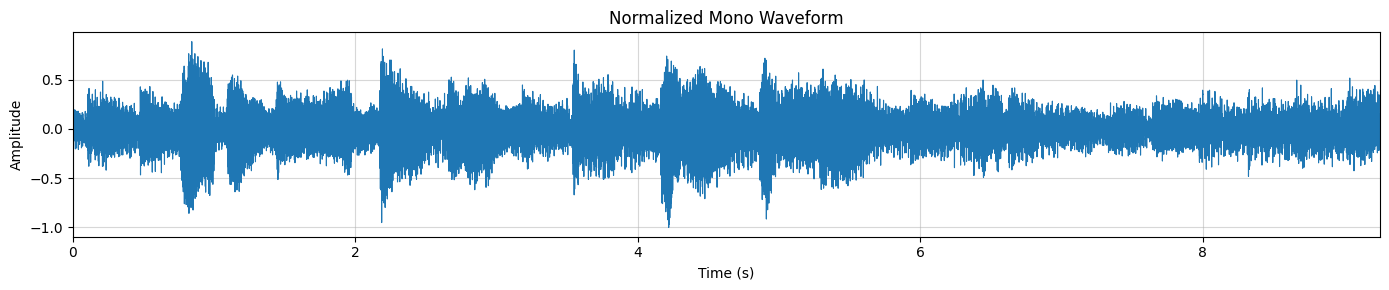

In [4]:
t = np.arange(len(audio)) / sr
fig = plt.figure(figsize=(14,3))
plt.plot(t, audio, linewidth=0.8)
plt.xlim(0, t[-1])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Normalized Mono Waveform")
plt.tight_layout()
plt.grid(True,alpha=0.5)
plt.show()

In [5]:
def frame_signal(x, frame_length, hop):
    """
    Return list of frames generated using standard sliding window logic.
    No padding. Pure framing.

    x: waveform (1-D numpy array)
    frame_length: samples per frame (int)
    hop: samples between consecutive frames (int)

    Returns:
        frames: list of 1-D numpy arrays, each of length `frame_length`
    """
    frames = []
    n = len(x)
    n_frames = 1 + (n - frame_length) // hop if n >= frame_length else 0

    for i in range(n_frames):
        start = i * hop
        end = start + frame_length
        frames.append(x[start:end])

    return frames

In [6]:
# parameters
SR = 16000
FRAME_LENGTH = int(0.032 * SR)   # 32 ms = 512
HOP          = int(0.020 * SR)   # 20 ms = 320

# generate frames
frames = frame_signal(audio, FRAME_LENGTH, HOP)

# report
print("Audio length (samples):", len(audio))
print("Frame length:", FRAME_LENGTH)
print("Hop:", HOP)
print("Total frames:", len(frames))

Audio length (samples): 148082
Frame length: 512
Hop: 320
Total frames: 462


In [7]:
pv_path = "/home/batch_2024/ee24s004/KT/RMVPE-RRCGD-spot-computation/dataset/train/amy_1_07.pv"
pitch_vals = np.loadtxt(pv_path, usecols=0)

print("Pitch shape:", pitch_vals.shape)
print("Length (frames):", len(pitch_vals))

Pitch shape: (461,)
Length (frames): 461


In [8]:
pitch_vals

array([ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    , 66.5053, 66.9225, 66.9225, 67.35  , 67.7883, 67.7883,
       67.7883, 68.238 , 68.238 , 67.7883, 67.7883, 67.7883, 67.7883,
       67.7883,  0.    ,  0.    ,  0.    , 69.6617, 68.6997, 68.6997,
       68.6997, 69.174 , 69.174 , 69.174 , 69.6617, 69.6617, 69.174 ,
       68.6997, 67.7883, 66.5053,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    , 67.7883, 68.238 , 68.238 , 69.174 , 69.6617, 69.6617,
       70.1635, 70.1635, 70.1635, 70.1635, 70.6804, 70.6804, 70.6804,
       71.2131, 71.7627, 71.7627, 72.3304, 72.3304, 72.3304, 72.3304,
       72.3304, 72.9173, 72.9173, 72.9173, 72.9173, 72.9173, 72.9173,
       72.3304,  0. 

In [9]:
# remove the first 1 frames
frames_shifted = frames[1:]        # still a list

print("Frames after removing 1 shift:", len(frames_shifted))
print("PV length:", len(pitch_vals))
print("Difference:", len(frames_shifted) - len(pitch_vals))

Frames after removing 1 shift: 461
PV length: 461
Difference: 0


In [10]:
# ----- Identify unvoiced frames -----
pitch_vals = np.array(pitch_vals)  # ensure numpy

unvoiced_idx = np.where(pitch_vals == 0)[0]
voiced_idx   = np.where(pitch_vals != 0)[0]

print("Total frames:", len(pitch_vals))
print("Voiced frames:", len(voiced_idx))
print("Unvoiced frames:", len(unvoiced_idx))

# Print some example unvoiced indices
print("Example unvoiced frame indices:", unvoiced_idx[:20])

# Extract pitch values of unvoiced regions (all zero)
unvoiced_pitch_values = pitch_vals[unvoiced_idx]
print("Unique pitch values in unvoiced region:", np.unique(unvoiced_pitch_values))

Total frames: 461
Voiced frames: 209
Unvoiced frames: 252
Example unvoiced frame indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Unique pitch values in unvoiced region: [0.]


In [11]:
# Find contiguous unvoiced blocks
blocks = []
current = []

for idx in unvoiced_idx:
    if not current or idx == current[-1] + 1:
        current.append(idx)
    else:
        blocks.append(current)
        current = [idx]
if current:
    blocks.append(current)

print("Number of unvoiced segments:", len(blocks))
print("First 5 unvoiced blocks:", blocks[:5])

Number of unvoiced segments: 9
First 5 unvoiced blocks: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], [50, 51, 52], [66, 67, 68, 69, 70], [99, 100, 101, 102, 103, 104, 105, 106], [153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174]]


In [12]:
# voiced region = indices where pitch != 0
voiced_idx = np.where(pitch_vals != 0)[0]

print("Voiced frame count:", len(voiced_idx))
print("First 20 voiced frame indices:", voiced_idx[:20])

# verify if any zero exists inside voiced region
zeros_inside_voiced = np.where(pitch_vals[voiced_idx] == 0)[0]

print("Any zeros inside voiced region?", len(zeros_inside_voiced) > 0)
print("Count of zeros wrongly inside voiced:", len(zeros_inside_voiced))

Voiced frame count: 209
First 20 voiced frame indices: [36 37 38 39 40 41 42 43 44 45 46 47 48 49 53 54 55 56 57 58]
Any zeros inside voiced region? False
Count of zeros wrongly inside voiced: 0


In [13]:
voiced_pitch_vals = pitch_vals[voiced_idx]
print("Min voiced pitch:", voiced_pitch_vals.min())
print("Max voiced pitch:", voiced_pitch_vals.max())
print("Example voiced pitches:", voiced_pitch_vals[:20])

Min voiced pitch: 60.6214
Max voiced pitch: 72.9173
Example voiced pitches: [66.5053 66.9225 66.9225 67.35   67.7883 67.7883 67.7883 68.238  68.238
 67.7883 67.7883 67.7883 67.7883 67.7883 69.6617 68.6997 68.6997 68.6997
 69.174  69.174 ]


In [34]:
def compute_roots_of_frame(frame: np.ndarray):
    window = np.hanning(len(frame))
    frame_w = (frame * window).astype(np.float64)
    poly = frame_w[::-1]

    try:
        roots = np.roots(poly)
    except Exception:
        return np.zeros(len(frame) - 1, dtype=np.complex64)

    # ensure exact length = frame_length - 1
    L = len(frame) - 1
    if len(roots) < L:
        pad = np.zeros(L - len(roots), dtype=np.complex64)
        roots = np.concatenate([roots, pad])
    elif len(roots) > L:
        roots = roots[:L]

    return roots

In [35]:
# -----------------------------------------
# Loop over all frames, compute roots
# -----------------------------------------

all_roots = []    # list to collect roots per-frame

for i, frame in enumerate(frames_shifted):
    r = compute_roots_of_frame(frame)
    all_roots.append(r)

all_roots = np.array(all_roots, dtype=object)   # shape: (T,) of variable-length complex arrays
print("Total frames:", len(all_roots))

Total frames: 461


In [36]:
def plot_roots_zplane_frame(roots, idx):
    # clean conversion
    roots = np.asarray(roots, dtype=np.complex128)
    real = np.real(roots).astype(float)
    imag = np.imag(roots).astype(float)

    plt.figure(figsize=(5,5))
    plt.scatter(real, imag, s=10)

    θ = np.linspace(0, 2*np.pi, 400)
    plt.plot(np.cos(θ), np.sin(θ), '--', linewidth=1)

    plt.axhline(0, color="black", linewidth=0.4)
    plt.axvline(0, color="black", linewidth=0.4)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(f"Z-Plane Roots – Frame {idx}")
    plt.show()

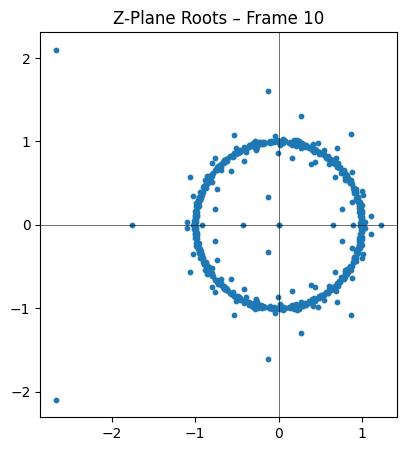

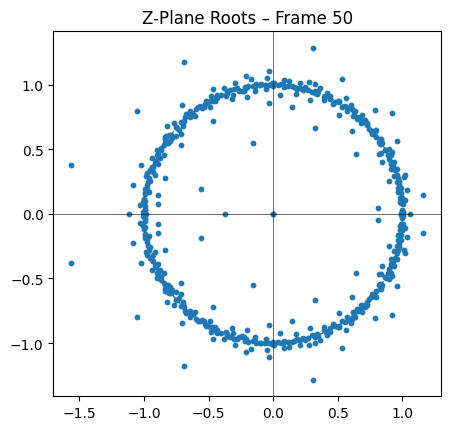

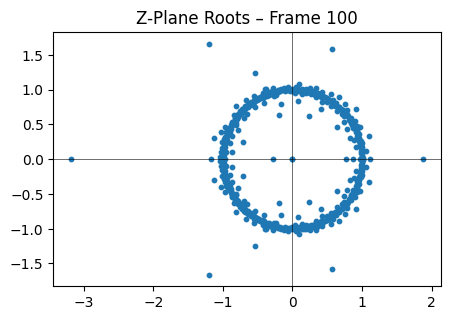

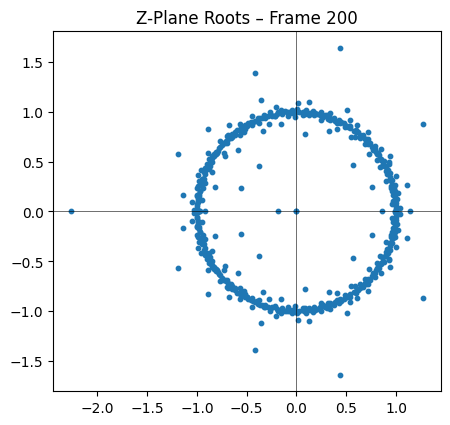

In [37]:
idxs = [10, 50, 100, 200]

for idx in idxs:
    if idx < all_roots.shape[0]:
        plot_roots_zplane_frame(all_roots[idx], idx)

In [38]:
print(type(all_roots), getattr(all_roots, "dtype", None))

<class 'numpy.ndarray'> object


In [39]:
print("type(all_roots):", type(all_roots))

# If ndarray, print its shape + dtype
if isinstance(all_roots, np.ndarray):
    print("shape(all_roots):", all_roots.shape)
    print("dtype:", all_roots.dtype)

# If list (ragged), print item count and each item length
elif isinstance(all_roots, list):
    print("len(all_roots):", len(all_roots))
    print("first 5 lengths:", [len(all_roots[i]) for i in range(min(5, len(all_roots)))])
    print("min len:", min(len(f) for f in all_roots))
    print("max len:", max(len(f) for f in all_roots))

type(all_roots): <class 'numpy.ndarray'>
shape(all_roots): (461, 511)
dtype: object


In [40]:
def rrcgd_single_frame(roots, r0=1.008, n_points=512):
    roots = np.asarray(roots, dtype=np.complex64)

    # reflect roots outside unit circle
    mag = np.abs(roots)
    ang = np.angle(roots)
    mask = mag > 1
    roots_ref = roots.copy()
    roots_ref[mask] = (1.0 / mag[mask]) * np.exp(1j * ang[mask])

    # evaluate chirp group delay
    w = np.linspace(0, np.pi, n_points // 2)
    m = np.abs(roots_ref)[:, None]
    theta = np.angle(roots_ref)[:, None]
    w_grid = w[None, :]

    num = m**2 - m * r0 * np.cos(w_grid - theta)
    den = r0**2 + m**2 - 2 * m * r0 * np.cos(w_grid - theta)

    gd = (num / (den + 1e-9)).sum(axis=0)
    return gd.astype(np.float32)

Text(0.5, 1.0, 'RRCGD of Frame 50')

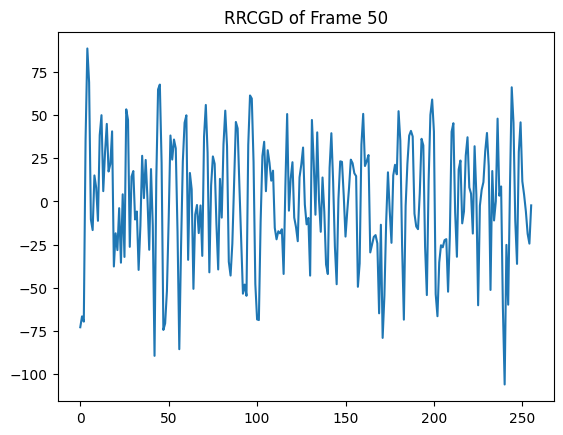

In [41]:
frame_roots = all_roots[50]
rr = rrcgd_single_frame(frame_roots)
plt.plot(rr); plt.title("RRCGD of Frame 50")

In [42]:
rrcgd_full = np.vstack([rrcgd_single_frame(f) for f in all_roots])

In [43]:
def plot_rrcgd_spectrogram(rrcgd, title="RRCGD Spectrogram"):
    """
    rrcgd : numpy array of shape (T, F)
    """
    if rrcgd is None or len(rrcgd) == 0:
        print("RRCGD is empty – nothing to plot.")
        return

    rrcgd = np.asarray(rrcgd)

    plt.figure(figsize=(14, 4))
    plt.imshow(
        rrcgd.T,
        aspect="auto",
        origin="lower",
        cmap="magma"
    )
    plt.colorbar(label="Group Delay (summed over roots)")
    plt.xlabel("Frame Index")
    plt.ylabel("Frequency Bin")
    plt.title(title)
    plt.tight_layout()
    plt.show()

(461, 256)


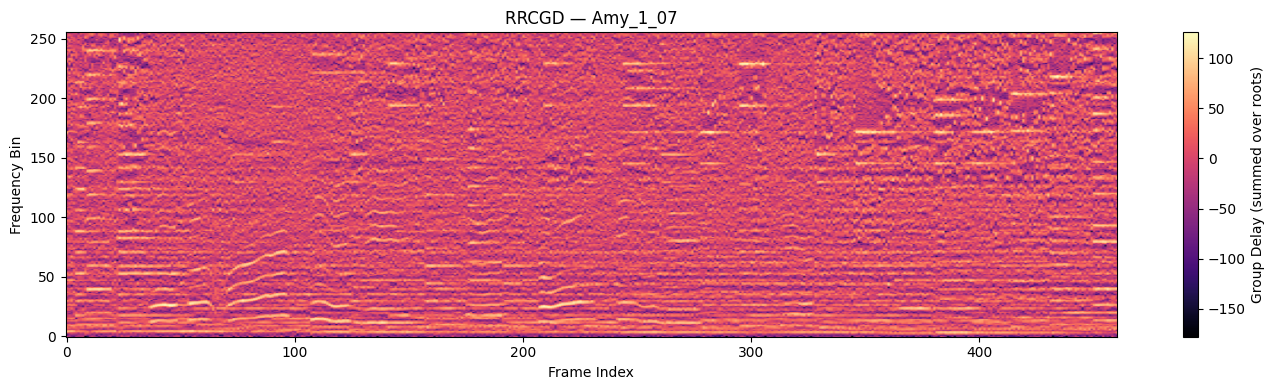

In [44]:
# assume rrcgd_full = np.vstack([rrcgd_single_frame(f) for f in all_roots])
print(rrcgd_full.shape)  
plot_rrcgd_spectrogram(rrcgd_full, title="RRCGD — Amy_1_07")

In [45]:
rrcgd_full.shape

(461, 256)

In [46]:
pitch_vals.shape

(461,)

Batch processing for all files

In [47]:
import os
import numpy as np
import soundfile as sf
import librosa
from tqdm import tqdm

In [52]:
SR = 16000

BASE_DIR = "/home/batch_2024/ee24s004/KT/RMVPE-RRCGD-spot-computation/dataset"

def process_file_and_save(audio_path, pv_path, roots_dir, rrcgd_dir):
    # ---- Load audio ----
    audio, sr = sf.read(audio_path)
    if sr != SR:
        audio = librosa.resample(audio, sr, SR)
    if audio.ndim > 1:
        audio = audio.mean(axis=1)
    audio = audio / (np.max(np.abs(audio)) + 1e-9)

    # ---- Frames ----
    frames = frame_signal(audio, FRAME_LENGTH, HOP)  # (T, 512)
    orig_T = len(frames)

    # ---- Load PV length ----
    pitch_vals = np.loadtxt(pv_path, usecols=0)
    pv_len = len(pitch_vals)

    # ---- MIR-1K alignment: drop first first 20ms  ----
    if orig_T > 1:
        frames = frames[1:]

    # ---- Compute roots ----
    roots = np.vstack([compute_roots_of_frame(f) for f in frames])  # (T, 511)
    
    # ---- Compute RRCGD ----
    rrcgd_all = np.vstack([rrcgd_single_frame(r) for r in roots])  # (T, 256)
    rrcgd_all = rrcgd_all[:pv_len]  # final align

    # ---- Save ----
    fname = os.path.basename(audio_path).replace(".wav","")
    np.save(os.path.join(roots_dir, fname + ".npy"), roots.astype(np.complex64))
    np.save(os.path.join(rrcgd_dir, fname + "_rrcgd.npy"), rrcgd_all.astype(np.float32))

    return orig_T, len(rrcgd_all), pv_len


def batch_process(split, limit=None):
    split_dir = os.path.join(BASE_DIR, split)
    wav_files = sorted([f for f in os.listdir(split_dir) if f.endswith(".wav")])
    
    roots_dir = os.path.join(split_dir, "roots")
    rrcgd_dir = os.path.join(split_dir, "rrcgd")
    os.makedirs(roots_dir, exist_ok=True)
    os.makedirs(rrcgd_dir, exist_ok=True)

    if limit is not None:
        wav_files = wav_files[:limit]

    print(f"\n=== BATCH → {split.upper()} ===")
    print(f"Found {len(wav_files)} wav files")

    for f in tqdm(wav_files, desc=f"Processing {split}", ncols=100):
        base = f[:-4]
        out_r = os.path.join(roots_dir, base + ".npy")
        out_g = os.path.join(rrcgd_dir, base + "_rrcgd.npy")

        # Skip already processed
        if os.path.exists(out_r) and os.path.exists(out_g):
            continue
        
        audio_path = os.path.join(split_dir, f)
        pv_path    = os.path.join(split_dir, base + ".pv")
        if not os.path.exists(pv_path):
            continue

        process_file_and_save(audio_path, pv_path, roots_dir, rrcgd_dir)

    print(f"=== DONE: {split.upper()} ===\n")


In [ ]:
# from multiprocessing import Pool, cpu_count

# def process_one(args):
#     audio_path, pv_path, roots_dir, rrcgd_dir = args
#     try:
#         process_file_and_save(audio_path, pv_path, roots_dir, rrcgd_dir)
#     except:
#         pass

# def batch_process_fast(split):
#     split_dir = os.path.join(BASE_DIR, split)
#     wav_files = sorted([f for f in os.listdir(split_dir) if f.endswith(".wav")])

#     roots_dir = os.path.join(split_dir, "roots")
#     rrcgd_dir = os.path.join(split_dir, "rrcgd")
#     os.makedirs(roots_dir, exist_ok=True)
#     os.makedirs(rrcgd_dir, exist_o k=True)

#     jobs = []
#     for f in wav_files:
#         base = f[:-4]
#         pv = os.path.join(split_dir, base + ".pv")
#         if not os.path.exists(pv):
#             continue

#         out_r = os.path.join(roots_dir, base + ".npy")
#         out_g = os.path.join(rrcgd_dir, base + "_rrcgd.npy")
#         if os.path.exists(out_r) and os.path.exists(out_g):
#             continue

#         jobs.append((os.path.join(split_dir, f), pv, roots_dir, rrcgd_dir))

#     print("CPU workers:", cpu_count())
#     with Pool(cpu_count()) as p:
#         list(tqdm(p.imap_unordered(process_one, jobs), total=len(jobs), ncols=100))


In [53]:
batch_process("train")   # full train


=== BATCH → TRAIN ===
Found 800 wav files


Processing train: 100%|████████████████████████████████████████| 800/800 [21:51:21<00:00, 98.35s/it]

=== DONE: TRAIN ===



In [54]:
batch_process("test")    # full test


=== BATCH → TEST ===
Found 250 wav files


Processing test: 100%|██████████████████████████████████████████| 250/250 [6:52:09<00:00, 98.92s/it]

=== DONE: TEST ===

